## Hierarchical Multi Agent System

![ma](images/hierarchical_ma.JPG)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import cfg
import functools
from typing import List
from src import agents, prompts, states, tools, members
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

USER_AGENT environment variable not set, consider setting it to identify your requests.
/home/saurabh/anaconda3/envs/llm_agent/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The function `convert_pydantic_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.3.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


In [3]:
## Define Model & tools
llm = cfg.llm

## Research Team

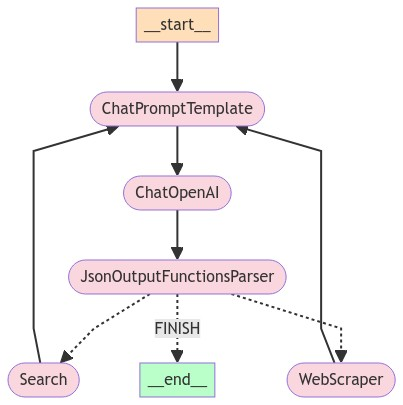

In [4]:
research_team_supervisor_template = prompts.research_team_supervisor_template.partial(research_team_members = members.research_team_members,
                                                  options = members.research_team_options)

## Create agent
research_team_supervisor = agents.create_supervisor_chain(llm, prompt=research_team_supervisor_template, 
                               functions = members.research_team_functions,
                               function_call= members.research_team_function_call)
search_agent = agents.create_agent(llm , tools = [tools.tavily_tool], prompt=prompts.searcher_template)
scrapper_agent = agents.create_agent(llm, tools=[tools.scrape_webpages], prompt=prompts.scrapper_template)

## Create Node
search_node = functools.partial(agents.agent_node, name = "Search", agent = search_agent)
scrapper_node = functools.partial(agents.agent_node, name = "WebScraper", agent = scrapper_agent)

## Test the node
# search_node(state= {"messages": [HumanMessage(content="What is langchain")]})

## Create Graph
research_workflow = StateGraph(states.ResearchTeamState)
# Add Node
research_workflow.add_node('Search', search_node)
research_workflow.add_node('WebScraper', scrapper_node)
research_workflow.add_node('supervisor', research_team_supervisor)
# Add Edge
_ = [research_workflow.add_edge(member, 'supervisor') for member in members.research_team_members]
research_workflow.add_conditional_edges('supervisor',
                                        lambda x: x['next'],
                                        {
                                            "Search": "Search", 
                                            "WebScraper": "WebScraper", 
                                            "FINISH": END
                                        }
                                        )

research_workflow.add_edge(START, 'supervisor')
# Compile Graph
research_graph = research_workflow.compile()
# Display graph
display(Image(research_graph.get_graph(xray=True).draw_mermaid_png()))


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | research_graph

In [5]:
# ## Test Research Graph
# input = "What is Langchain?"

# for s in research_chain.stream(input, {"recursion_limit": 10}):
#     if "__end__" not in s:
#         print(s)
#         print("---")

# Doc Writing Team

In [6]:
# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
WORKING_DIRECTORY = tools.WORKING_DIRECTORY

def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

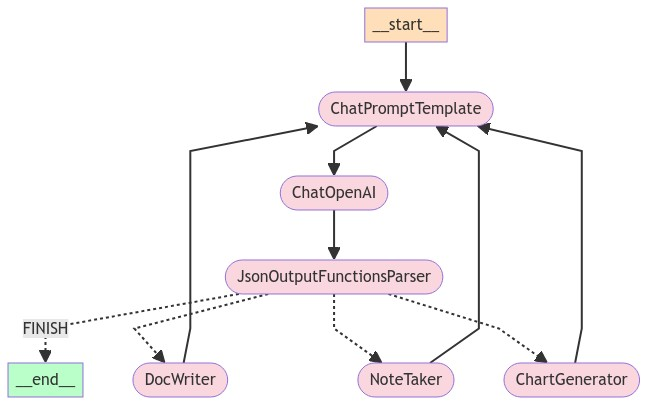

In [7]:
doc_writer_team_supervisor_template = prompts.doc_writing_team_supervisor_template.partial(
                                                doc_writer_members = members.doc_writing_members,
                                                options = members.doc_writing_options)

## Create agent
doc_writer_supervisor = agents.create_supervisor_chain(llm, prompt=doc_writer_team_supervisor_template, 
                               functions = members.doc_writing_functions,
                               function_call= members.doc_writing_function_call)


writer_agent = agents.create_agent(llm , 
                                   tools=[tools.write_document, tools.read_document, tools.edit_document], 
                                   prompt=prompts.writer_template)
note_taker_agent = agents.create_agent(llm , 
                                       tools=[tools.create_outline, tools.read_document], 
                                       prompt=prompts.note_taker_template)
chart_gen_agent = agents.create_agent(llm , 
                                      tools=[tools.python_repl, tools.read_document], 
                                      prompt=prompts.chart_gen_template)


context_aware_doc_writer_agent = prelude | writer_agent
context_aware_note_taking_agent = prelude | note_taker_agent
context_aware_chart_generating_agent = prelude | chart_gen_agent

## create node
writer_node = functools.partial(agents.agent_node, 
                                agent = context_aware_doc_writer_agent, name = 'DocWriter')
note_taker_node = functools.partial(agents.agent_node, 
                                agent = context_aware_note_taking_agent, name = 'NoteTaker')
chart_gen_node = functools.partial(agents.agent_node, 
                                agent = context_aware_chart_generating_agent, name = 'ChartGenerator')


## Create Graph
docWriter_workflow = StateGraph(states.DocWritingState)
# Add Node
docWriter_workflow.add_node('DocWriter', writer_node)
docWriter_workflow.add_node('NoteTaker', note_taker_node)
docWriter_workflow.add_node('ChartGenerator', chart_gen_node)
docWriter_workflow.add_node('supervisor', doc_writer_supervisor)
# Add Edge
_ = [docWriter_workflow.add_edge(member, 'supervisor') for member in members.doc_writing_members]
conditional_map = {k:k for k in members.doc_writing_options}
conditional_map['FINISH']  = END
docWriter_workflow.add_conditional_edges('supervisor',
                                        lambda x: x['next'],
                                        conditional_map
                                        )

docWriter_workflow.add_edge(START, 'supervisor')
# Compile Graph
docWriter_graph = docWriter_workflow.compile()
# Display graph
display(Image(docWriter_graph.get_graph(xray=True).draw_mermaid_png()))


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=docWriter_graph.nodes)
    | docWriter_graph
)


In [8]:
# input = "Write an outline for poem and then write the poem to disk."

# for s in authoring_chain.stream(input,{"recursion_limit": 10}):
#     if "__end__" not in s:
#         print(s)
#         print("---")

## Combine both graph

In [9]:
def get_last_message(state: states.SupervisorState) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

In [10]:
supervisor_template = prompts.supervisor_template.partial(
                                                team_members = members.supervisor_members,
                                                options = members.supervisor_options)

## Create agent
supervisor_chain = agents.create_supervisor_chain(llm, prompt=supervisor_template, 
                               functions = members.supervisor_functions,
                               function_call= members.supervisor_function_call)


## Create Graph
workflow = StateGraph(states.SupervisorState)
# Add Node
workflow.add_node('supervisor', supervisor_chain)
workflow.add_node('ResearchTeam', get_last_message | research_chain  | join_graph)
workflow.add_node('PaperWritingTeam', get_last_message | authoring_chain  | join_graph)


# Add Edge
_ = [workflow.add_edge(member, 'supervisor') for member in members.supervisor_members]
conditional_map = {k:k for k in members.supervisor_options}
conditional_map['FINISH']  = END
workflow.add_conditional_edges('supervisor',
                                        lambda x: x['next'],
                                        conditional_map
                                        )

workflow.add_edge(START, 'supervisor')
# Compile Graph
graph = workflow.compile()

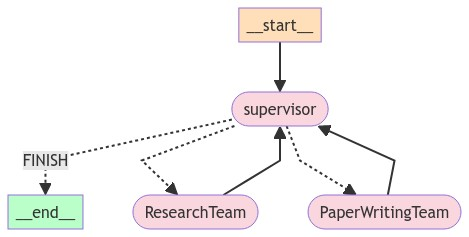

In [11]:
Image(graph.get_graph().draw_mermaid_png())

## Test Agent

In [14]:
# input = "Write a brief research report on the North American sturgeon. Include a chart."
# for s in graph.stream(
#     {
#         "messages": [HumanMessage(content=input)],
#     },
#     {"recursion_limit": 20},
# ):
#     if "__end__" not in s:
#         print(s)
#         print("---")